In [1]:
import pandas as pd
import decoupler as dc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad

/home/roger/anaconda3/envs/rnaseqdc/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/roger/anaconda3/envs/rnaseqdc/lib/python3.13/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
import decoupler
print(decoupler.__version__)


2.0.1


In [33]:
#mat = pd.read_csv("/mnt/c/Users/Roger/Downloads/kallisto.100/kallisto.100/DESeq2_TPM_values.tsv", sep="\t", index_col = 0) # 
mat = pd.read_csv("/mnt/c/Users/Roger/Downloads/adjusted_counts.tsv", sep="\t", index_col = 0) # i did round  those are the batch corrected

metadata = pd.read_csv("/mnt/c/Users/Roger/Downloads/metadata.tsv", sep="\t")

In [34]:
metadata = metadata[metadata['run'] == 72]

In [35]:
metadata = metadata[metadata['time'] == 'four']
metadata = metadata[metadata['treatment'] != 'TNFa']

In [36]:
metadata

,run,sampleID,experiment,time,treatment,replicate
2,72,072_71,1,four,zero,1
3,72,072_72,1,four,zero,2
4,72,072_73,1,four,five_epi,1
5,72,072_74,1,four,five_epi,2
6,72,072_75,1,four,five_nor,1
7,72,072_76,1,four,five_nor,2
8,72,072_77,1,four,mix,1
9,72,072_78,1,four,mix,2
24,72,072_161,2,four,zero,1
25,72,072_162,2,four,zero,2


In [37]:
# remove rows that have all 0s
mat = mat.loc[~(mat == 0).all(axis=1)]

In [38]:
df_T = mat.transpose()  # Now rows = samples and columns = genes

In [39]:
four = df_T[df_T.index.isin(metadata['sampleID'])]

In [40]:

def plot_pca_umap(df, metadata, hue1="treatment", hue2="time"):
    # Step 1: Set index to sampleID in metadata to match df_T
    metadata = metadata.set_index('sampleID')
    df.index.name = 'sampleID'
    df.index = df.index.astype(str)

    df2 = df.join(metadata, how="inner")
    X = StandardScaler().fit_transform(df2[df.columns])
    pcs = PCA(n_components=2, random_state=42).fit_transform(X)
    ums = umap.UMAP(random_state=42).fit_transform(X)
    plot_df = pd.DataFrame({
        "PC1": pcs[:,0], "PC2": pcs[:,1],
        "UMAP1": ums[:,0], "UMAP2": ums[:,1],
        hue1: df2[hue1].values, hue2: df2[hue2].values
    }, index=df2.index)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    sns.scatterplot(data=plot_df, x="PC1", y="PC2", hue=hue1, style=hue2, ax=ax1, s=80)
    ax1.set_title("PCA")
    sns.scatterplot(data=plot_df, x="UMAP1", y="UMAP2", hue=hue1, style=hue2, ax=ax2, s=80)
    ax2.set_title("UMAP")
    plt.tight_layout()
    plt.show()

/home/roger/anaconda3/envs/rnaseqdc/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


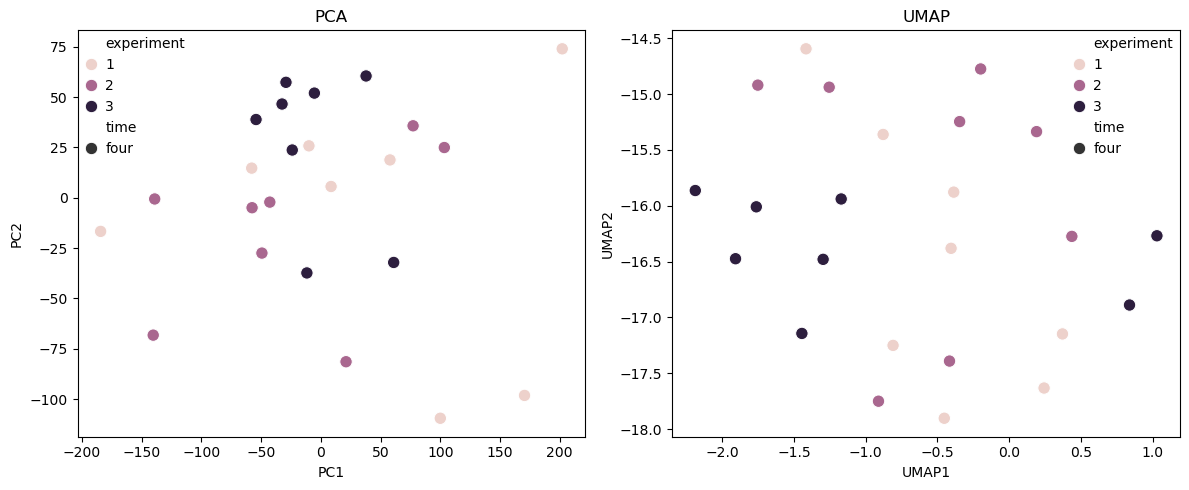

In [41]:
plot_pca_umap(df_T, metadata, hue1="experiment", hue2="time")

In [42]:
#Create AnnData object
adata = ad.AnnData(X=four.values, obs=metadata, var=pd.DataFrame(index=four.columns))   #or df_T

# Optionally set sample and gene names
adata.obs_names = four.index       # sample IDs
adata.var_names = four.columns     # gene symbols

/home/roger/anaconda3/envs/rnaseqdc/lib/python3.13/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [43]:
adata

AnnData object with n_obs × n_vars = 24 × 28767
    obs: 'run', 'sampleID', 'experiment', 'time', 'treatment', 'replicate'

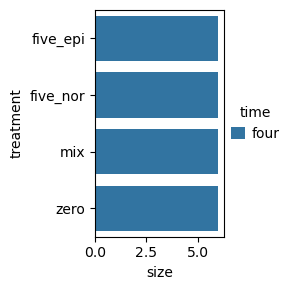

In [44]:
dc.pl.obsbar(
    adata=adata,
    y='treatment',
    hue='time',
    figsize=(3, 3)
)

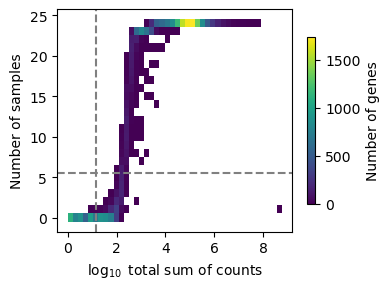

In [45]:
dc.pl.filter_by_expr(
    adata=adata,
    group='treatment',
    min_count=10,
    min_total_count=15,
    large_n=10,
    min_prop=0.7,
)

In [46]:
dc.pp.filter_by_expr(
    adata=adata,
    group='treatment',
    min_count=10,
    min_total_count=15,
    large_n=10,
    min_prop=0.7,
)

In [47]:
import scanpy as sc
# Store raw counts in layers
adata.layers['counts'] = adata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)

# Return raw counts to X
dc.pp.swap_layer(
    adata=adata,
    key='counts',
    inplace=True
)

In [48]:
adata

AnnData object with n_obs × n_vars = 24 × 17480
    obs: 'run', 'sampleID', 'experiment', 'time', 'treatment', 'replicate'
    var: 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'X'

In [49]:
# Return raw counts to X
dc.pp.swap_layer(
    adata=adata,
    key='counts',
    inplace=True
)

In [50]:
del adata.obs['sampleID']
del adata.obs['run']

In [51]:
del adata.obs['time']

In [52]:
dc.tl.rankby_obsm(adata, key='X_pca')

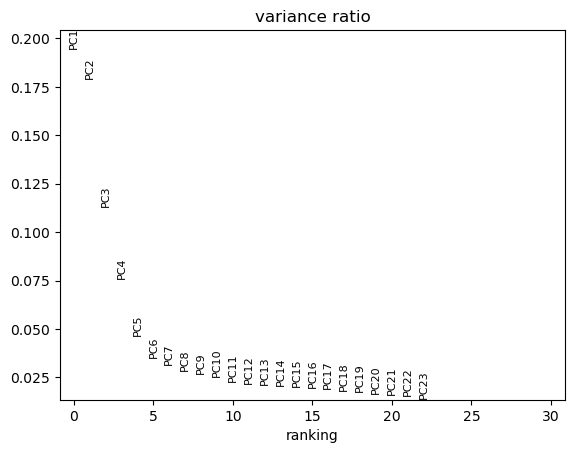

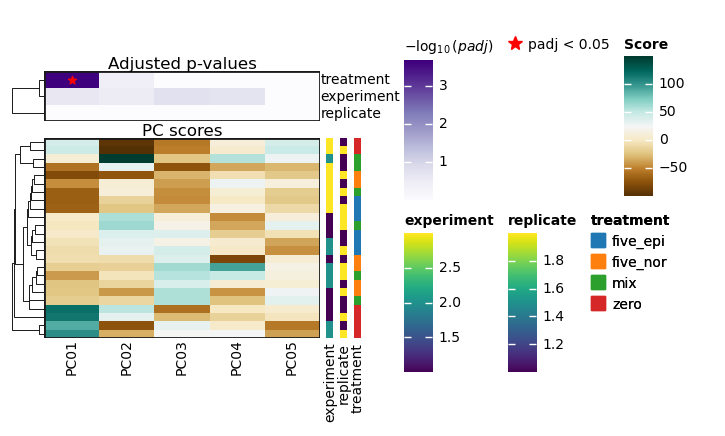

In [53]:
sc.pl.pca_variance_ratio(adata)
dc.pl.obsm(
    adata=adata,
    return_fig=True,
    nvar=5,
    titles=['PC scores', 'Adjusted p-values'],
    figsize=(6, 3)
)

... storing 'treatment' as categorical


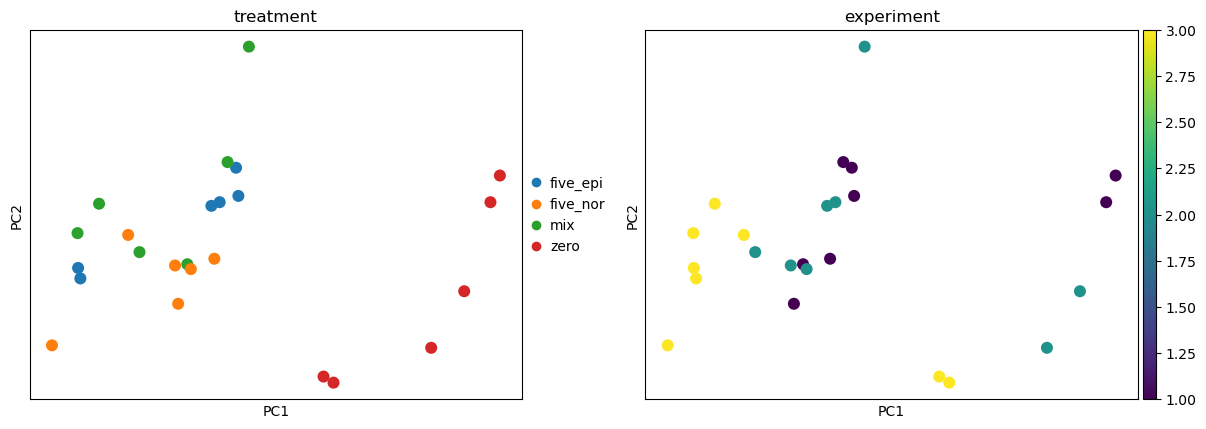

In [54]:
sc.pl.pca(
    adata,
    color=['treatment', 'experiment'],  # change experiment to non numbers
    ncols=3,
    size=300,
    frameon=True,
)

In [55]:
# genes removed
# MTND2P30", "RPL23AP95", "USP9YP10

In [56]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

# Build DESeq2 object
inference = DefaultInference(n_cpus=10)
dds = DeseqDataSet(
    adata=adata,
    design_factors='experiment + treatment',  #only treatment  #add ~ experiment + treatment', if we want to reduce batch effect
    refit_cooks=True,
    inference=inference,
)

# Compute LFCs
dds.deseq2()

# Extract contrast between conditions
stat_res = DeseqStats(
    dds,
    contrast=["treatment", 'mix', 'zero'],
    inference=inference
)

# Compute Wald test
stat_res.summary()

/tmp/ipykernel_666691/391258734.py:7: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.03 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 3.79 seconds.

Fitting dispersion trend curve...
... done in 0.84 seconds.

Fitting MAP dispersions...
... done in 5.83 seconds.

Fitting LFCs...
... done in 2.45 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.83 seconds.



Log2 fold change & Wald test p-value: treatment mix vs zero
              baseMean  log2FoldChange     lfcSE      stat        pvalue  \
C1orf122   3795.466513       -0.109368  0.070358 -1.554441  1.200793e-01   
CYP19A1      43.075817       -0.239519  0.199355 -1.201472  2.295681e-01   
SPATA17      91.629663        0.042764  0.215986  0.197994  8.430499e-01   
ZNF33B     1139.805584       -0.371241  0.081016 -4.582326  4.598332e-06   
ZMIZ2     11834.474211       -0.031112  0.056865 -0.547121  5.842955e-01   
...                ...             ...       ...       ...           ...   
PAPOLG     1939.509047        0.292098  0.073727  3.961873  7.436423e-05   
SH2B2        90.144792        0.107996  0.166672  0.647956  5.170133e-01   
AMPD3       223.845459       -0.601925  0.105255 -5.718752  1.073091e-08   
CDH18       128.942212       -0.072740  0.131116 -0.554780  5.790451e-01   
SPDYE17      42.857491       -0.002095  0.208682 -0.010038  9.919911e-01   

                  padj  
C1

In [57]:
# Extract results
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
C1orf122,3795.466513,-0.109368,0.070358,-1.554441,1.200793e-01,2.660006e-01
CYP19A1,43.075817,-0.239519,0.199355,-1.201472,2.295681e-01,4.183972e-01
SPATA17,91.629663,0.042764,0.215986,0.197994,8.430499e-01,9.216388e-01
ZNF33B,1139.805584,-0.371241,0.081016,-4.582326,4.598332e-06,4.335534e-05
ZMIZ2,11834.474211,-0.031112,0.056865,-0.547121,5.842955e-01,7.538318e-01
...,...,...,...,...,...,...
PAPOLG,1939.509047,0.292098,0.073727,3.961873,7.436423e-05,5.414942e-04
SH2B2,90.144792,0.107996,0.166672,0.647956,5.170133e-01,7.015059e-01
AMPD3,223.845459,-0.601925,0.105255,-5.718752,1.073091e-08,1.497871e-07
CDH18,128.942212,-0.072740,0.131116,-0.554780,5.790451e-01,7.500501e-01


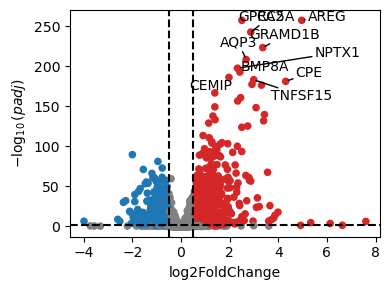

In [58]:
dc.pl.volcano(
    data=results_df,
    x='log2FoldChange',
    y='padj',
    top=10,
)

In [29]:
data = results_df[['stat']].T.rename(index={'stat': 'mix.vs.control'})
data


,PTAR1,LRRC23,ARHGEF16,LRRC4,DLG2,ANKRD19P,GLYAT,TP53TG5,AC106886.5,ALG6,...,KDM5D,TPPP3,PAPPA,SH2B2,AC093012.1,CRTAC1,CDH18,KLRF1,OR5A1,SPDYE18
mix.vs.control,0.07028,0.207439,-3.504985,2.434452,-0.730789,0.465396,4.13665,1.090459,2.347933,0.255916,...,1.364222,0.602204,2.628346,0.927005,0.86589,-0.581995,-0.572999,-0.095971,-0.152147,-0.228049


In [32]:
collectri = dc.op.collectri(organism='human')
collectri

,source,target,weight,resources,references,sign_decision
0,MYC,TERT,1.0,DoRothEA-A;ExTRI;HTRI;NTNU.Curated;Pavlidis202...,10022128;10491298;10606235;10637317;10723141;1...,PMID
1,SPI1,BGLAP,1.0,ExTRI,10022617,default activation
2,SMAD3,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
3,SMAD4,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
4,STAT5A,IL2,1.0,ExTRI,10022878;11435608;17182565;17911616;22854263;2...,default activation
...,...,...,...,...,...,...
42985,NFKB,hsa-miR-143-3p,1.0,ExTRI,19472311,default activation
42986,AP1,hsa-miR-206,1.0,ExTRI;GEREDB;NTNU.Curated,19721712,PMID
42987,NFKB,hsa-miR-21,1.0,ExTRI,20813833;22387281,default activation
42988,NFKB,hsa-miR-224-5p,1.0,ExTRI,23474441;23988648,default activation


In [59]:
collectri[collectri['target'] == "GRAMD1B"]

,source,target,weight,resources,references,sign_decision


In [60]:
# Run
tf_acts, tf_padj = dc.mt.ulm(data=data, net=collectri)

# Filter by sign padj
msk = (tf_padj.T < 0.05).iloc[:, 0]
tf_acts = tf_acts.loc[:, msk]

tf_acts

,ABL1,AHR,AP1,AR,ARID1A,ARID4B,ARX,ATF2,ATF4,ATF6,...,STAT5A,STAT5B,STAT6,TCF7L2,TEAD4,TFAP2A,TLX1,VHL,ZMYND8,ZNF384
mix.vs.control,-3.742186,3.054625,6.721065,4.782848,-2.918818,-3.904087,2.834296,5.280816,2.920435,3.563436,...,3.642442,3.615367,4.000854,2.986488,4.266759,4.6995,3.374298,-4.018066,-3.127511,3.546846


In [61]:
tf_acts.columns

Index(['ABL1', 'AHR', 'AP1', 'AR', 'ARID1A', 'ARID4B', 'ARX', 'ATF2', 'ATF4',
       'ATF6', 'BHLHE41', 'BRCA1', 'CEBPB', 'CREB1', 'CTNNB1', 'DMTF1', 'EGR1',
       'ESR1', 'FOS', 'FOSB', 'FOXA2', 'FOXC1', 'HAND1', 'HIF1A', 'HIF3A',
       'HMGA1', 'ID2', 'ID4', 'ING4', 'JARID2', 'JUN', 'JUND', 'KLF4', 'LMX1A',
       'LRRFIP1', 'MAFA', 'MITF', 'MTF2', 'MYF5', 'NFATC2', 'NFIL3', 'NFKB',
       'NHLH1', 'NKRF', 'NOTCH1', 'NPAS2', 'NR0B2', 'NR2E1', 'NR4A2', 'OLIG1',
       'PDX1', 'PGR', 'PITX3', 'RARA', 'RARG', 'RXRA', 'RXRB', 'RXRG', 'SMAD1',
       'SOX10', 'SP1', 'SSRP1', 'STAT5A', 'STAT5B', 'STAT6', 'TCF7L2', 'TEAD4',
       'TFAP2A', 'TLX1', 'VHL', 'ZMYND8', 'ZNF384'],
      dtype='object')

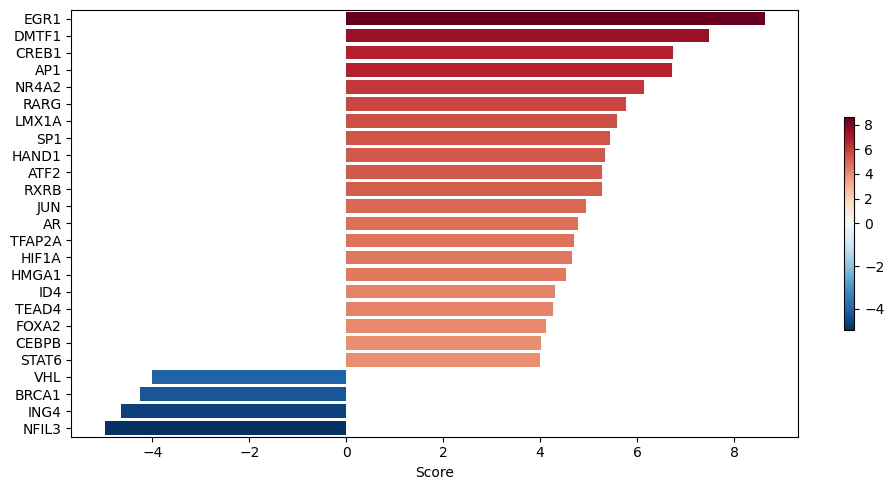

In [62]:
dc.pl.barplot(
    data=tf_acts,
    name='mix.vs.control',
    top=25,
    figsize=(10, 5)
)

In [ ]:
#HIF1A, CREB1, STAT3, CEBPB, and ATF2 

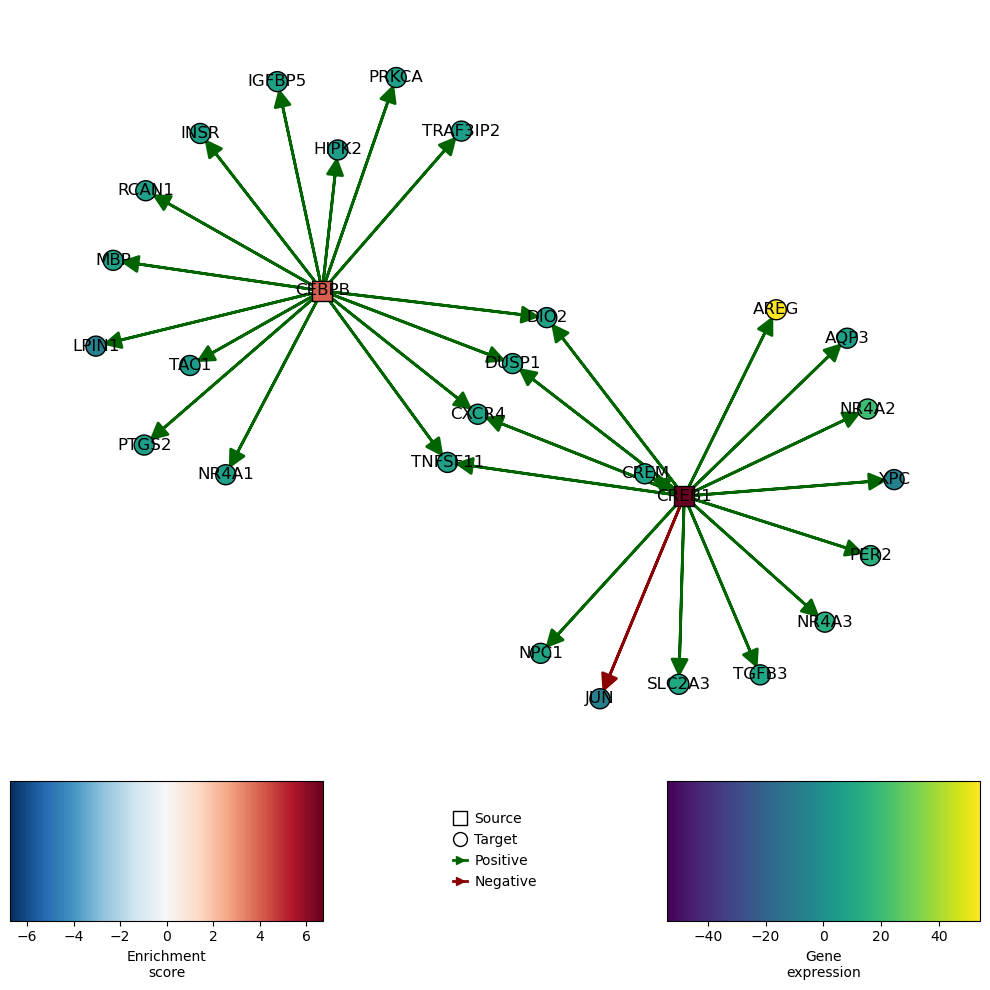

In [63]:
dc.pl.network(
    net=collectri,
    data=data,
    score=tf_acts,
    sources=['CEBPG',  'CREB1', 'CEBPB'],
    targets=15,
    figsize=(10, 10),
    vcenter=True,
    by_abs=True,
    size_node=20
)

In [64]:
tf_acts

,ABL1,AHR,AP1,AR,ARID1A,ARID4B,ARX,ATF2,ATF4,ATF6,...,STAT5A,STAT5B,STAT6,TCF7L2,TEAD4,TFAP2A,TLX1,VHL,ZMYND8,ZNF384
mix.vs.control,-3.742186,3.054625,6.721065,4.782848,-2.918818,-3.904087,2.834296,5.280816,2.920435,3.563436,...,3.642442,3.615367,4.000854,2.986488,4.266759,4.6995,3.374298,-4.018066,-3.127511,3.546846


In [ ]:
for tf in tf_acts.columns:
    dc.pl.volcano(
        data=results_df,
        x='log2FoldChange',
        y='pvalue',
        net=collectri,
        name=tf,
        top=10,
    )


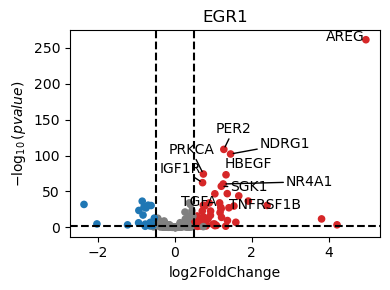

In [65]:
dc.pl.volcano(
    data=results_df,
    x='log2FoldChange',
    y='pvalue',
    net=collectri,
    name='EGR1',
    top=10,
)

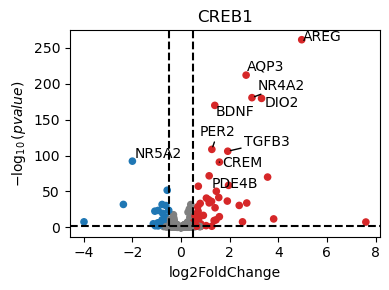

In [66]:
dc.pl.volcano(
    data=results_df,
    x='log2FoldChange',
    y='pvalue',
    net=collectri,
    name='CREB1',
    top=10,
)

In [67]:
progeny = dc.op.progeny(organism='human')
progeny

,source,target,weight,padj
0,Androgen,TMPRSS2,11.490631,2.384806e-47
1,Androgen,NKX3-1,10.622551,2.205102e-44
2,Androgen,MBOAT2,10.472733,4.632376e-44
3,Androgen,KLK2,10.176186,1.944410e-40
4,Androgen,SARG,11.386852,2.790210e-40
...,...,...,...,...
62456,p53,ENPP2,2.771405,4.993215e-02
62457,p53,ARRDC4,3.494328,4.996747e-02
62458,p53,MYO1B,-1.148057,4.997905e-02
62459,p53,CTSC,-1.784693,4.998864e-02


In [68]:
# Run
pw_acts, pw_padj = dc.mt.ulm(data=data, net=progeny)

# Filter by sign padj
msk = (pw_padj.T < 0.05).iloc[:, 0]
pw_acts = pw_acts.loc[:, msk]

pw_acts

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,p53
mix.vs.control,5.761318,9.965309,4.622606,7.995327,-2.896953,11.963664,5.650773,10.634549,9.49012,3.199108,-3.029159,11.046168,2.670851


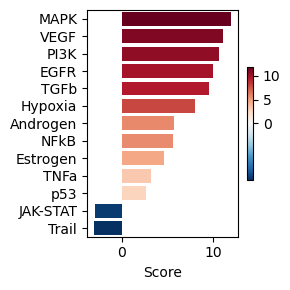

In [69]:
dc.pl.barplot(
    data=pw_acts,
    name='mix.vs.control',
    top=25,
    figsize=(3, 3)
)

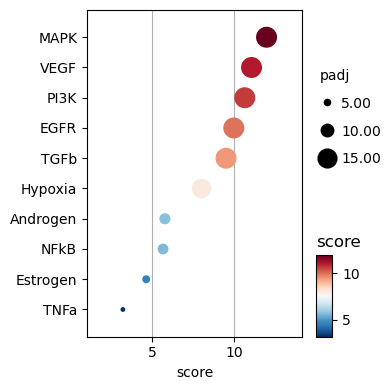

In [70]:
import numpy as np
# Tranform to df
df = (
    pw_acts
    .melt(value_name='score')
    .merge(
        pw_padj
        .melt(value_name='padj')
        .assign(padj=lambda x: x['padj'].clip(2.22e-16, 1))
        .assign(padj=lambda x: np.log10(x['padj']))
    )
)
dc.pl.dotplot(
    df=df,
    x='score',
    y='variable',
    s='padj',
    c='score',
    scale=0.15,
    figsize=(4, 4)
)

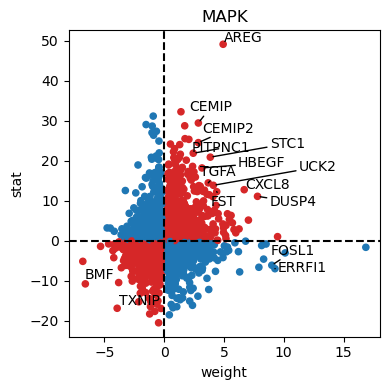

In [77]:
dc.pl.source_targets(
    data=results_df,
    x='weight',
    y='stat',
    net=progeny,
    name='MAPK',
    top=15,
    figsize=(4, 4)
)

(+) leading edge: ['NPTX1' 'CEMIP' 'TNFSF15' 'NR4A2' 'CLCF1']
(-) leading edge: ['SLC20A2' 'ERCC6' 'SH2D3C' 'TXNIP' 'VCL']


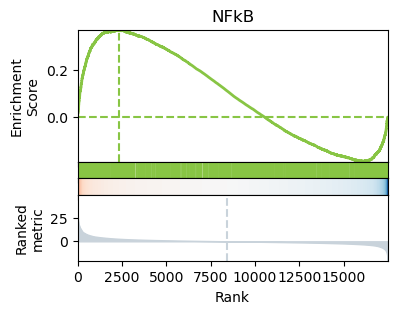

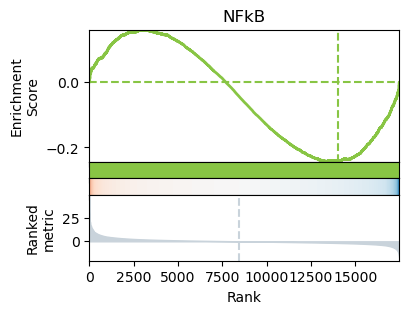

In [72]:
_, pos_le = dc.pl.leading_edge(
    results_df,
    stat='stat',
    net=progeny[progeny['weight'] > 0],
    name='NFkB',
)
print('(+) leading edge:', pos_le[:5])
_, neg_le = dc.pl.leading_edge(
    results_df,
    stat='stat',
    net=progeny[progeny['weight'] < 0],
    name='NFkB',
)
print('(-) leading edge:', neg_le[:5])

In [73]:
hallmark = dc.op.hallmark(organism='human')
hallmark

,source,target
0,IL2_STAT5_SIGNALING,MAFF
1,COAGULATION,MAFF
2,HYPOXIA,MAFF
3,TNFA_SIGNALING_VIA_NFKB,MAFF
4,COMPLEMENT,MAFF
...,...,...
7313,PANCREAS_BETA_CELLS,STXBP1
7314,PANCREAS_BETA_CELLS,ELP4
7315,PANCREAS_BETA_CELLS,GCG
7316,PANCREAS_BETA_CELLS,PCSK2


In [74]:
# Run
hm_acts, hm_padj = dc.mt.ulm(data=data, net=hallmark)

# Filter by sign padj
msk = (hm_padj.T < 0.05).iloc[:, 0]
hm_acts = hm_acts.loc[:, msk]

hm_acts

,ANDROGEN_RESPONSE,ANGIOGENESIS,DNA_REPAIR,E2F_TARGETS,EPITHELIAL_MESENCHYMAL_TRANSITION,ESTROGEN_RESPONSE_EARLY,ESTROGEN_RESPONSE_LATE,G2M_CHECKPOINT,GLYCOLYSIS,HEME_METABOLISM,HYPOXIA,IL2_STAT5_SIGNALING,INFLAMMATORY_RESPONSE,INTERFERON_ALPHA_RESPONSE,KRAS_SIGNALING_UP,OXIDATIVE_PHOSPHORYLATION,TNFA_SIGNALING_VIA_NFKB,UNFOLDED_PROTEIN_RESPONSE,UV_RESPONSE_DN
mix.vs.control,5.440114,3.823824,-2.802864,-4.805022,5.655378,7.202062,7.74796,-3.290894,3.174759,2.866067,4.604947,4.500623,2.618319,-2.408461,5.735055,-2.82577,8.202994,4.208111,3.78707


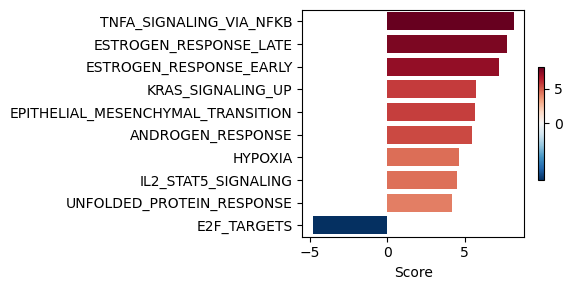

In [75]:
dc.pl.barplot(
    data=hm_acts,
    top=10,
    name='mix.vs.control',
    figsize=(6, 3)
)

leading edge: ['AREG' 'NR4A2' 'CLCF1' 'HBEGF' 'PDE4B']


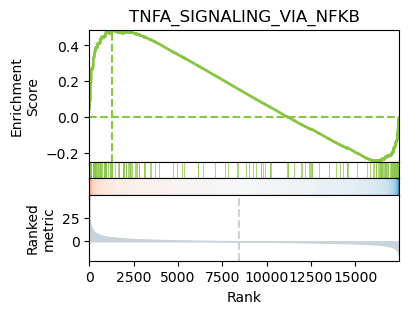

In [76]:
_, le = dc.pl.leading_edge(
    results_df,
    stat='stat',
    net=hallmark,
    name='TNFA_SIGNALING_VIA_NFKB',
)
print('leading edge:', le[:5])